In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astra
from skimage.transform import radon, rescale, rotate
from scipy.interpolate import RectBivariateSpline

astra.test()

ASTRA Toolbox v2.2.0
Getting GPU info... GPU #0: NVIDIA GeForce RTX 2070 SUPER, with 8191MB, CUDA compute capability 7.5
Testing basic CPU 2D functionality... Ok
Testing basic CUDA 2D functionality... Ok
Testing basic CUDA 3D functionality... Ok


During a scan we get $I$ which we know to be modeled by $$I = I_0 \exp(- \int \mu (x,y) \cdot ds)$$ where $ds$ is a straight line through the material. We re-arrange to get.

$$\ln(\dfrac{I_0}{I}) = \int \mu(x,y) ds$$

We will denote 
- $\mu (x,y) = f(x,y)$
- $\ln(\dfrac{I_0}{I}) = p(r,\theta)$
  - Where $\theta$ is the tilt of the scanner 
  - where $r$ is the horizontal offset of the scanner 

Our goal is reconstruct $f(x,y)$ given $p(\theta, r)$

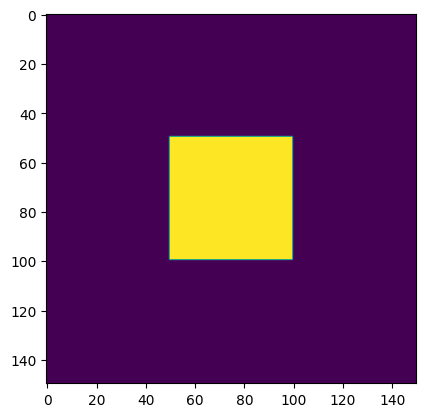

In [2]:
in_img = np.ones((50,50),dtype=np.float32)
in_img = np.pad(in_img, ((50,50), (50,50)), mode='constant', constant_values=0)
plt.imshow(in_img)

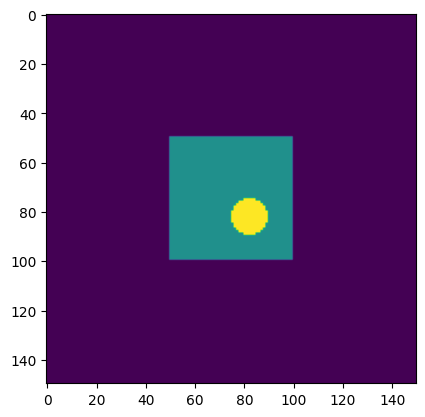

In [3]:
xv, yv = np.meshgrid(
    np.linspace(-1, 1, in_img.shape[1]),
    np.linspace(-1, 1, in_img.shape[0])
)
in_img[(xv-0.1)**2+(yv-0.1)**2<0.01] = 2
plt.imshow(in_img)

In [4]:
def get_scan(img, rads):
    # this our p(r, theta) for fixed r = 0 
    rotated = rotate(img, rads * 180 / np.pi)
    return np.sum(rotated, axis=0)

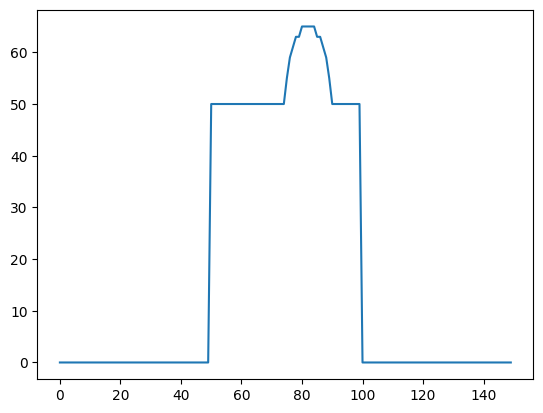

In [5]:
theta = 0
x = np.arange(in_img.shape[1])
y = get_scan(in_img, theta)
plt.plot(x,y)

### Plotting the Sinogram

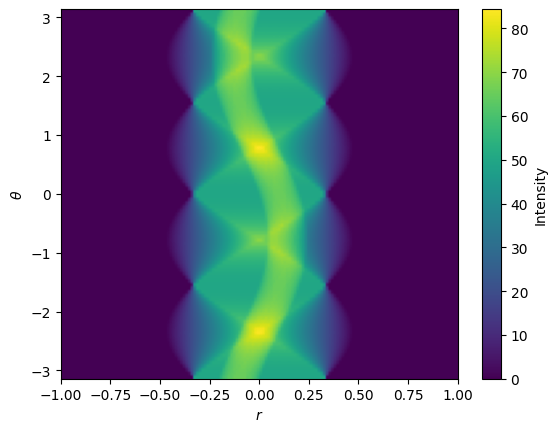

In [6]:
thetas = np.linspace(-np.pi,np.pi,100)
intensities = np.array([get_scan(in_img, theta) for theta in thetas])

# plt.imshow(intensities)
plt.ylabel(r'$\theta$')
plt.xlabel(r'$r$')
plt.imshow(intensities, extent=[-1, 1, -np.pi, np.pi], aspect='auto')
plt.colorbar(label='Intensity')

## Back projection
This is how we go from $r,\theta$ back to the original image. For a scan angle $\theta$ the value of $r$ that the point $(x,y)$ contributes is $x \cos \theta + y \sin \theta$ 

$$f_{BP} (x,y) =\int^{\pi}_0 p(x \cos \theta + y \sin \theta, \theta) \cdot d \theta \approx \sum_i p(x \cos \theta_i + y \sin \theta_i, \theta_i) \delta \theta_i$$

where $p$ the projection data (sinogram) for that value of $r$ and $\theta$.

In [7]:
xs = np.linspace(-1,1,in_img.shape[1])
p_interp = RectBivariateSpline(xs, thetas, intensities.T)

In [8]:
dtheta = thetas[1]-thetas[0]
def get_fBP(x,y):
    r = x * np.cos(thetas) + y * np.sin(thetas)
    return p_interp(r, thetas, grid=False).sum() * dtheta

fBP = np.vectorize(get_fBP)(xv,yv)

### Regular Backprojection

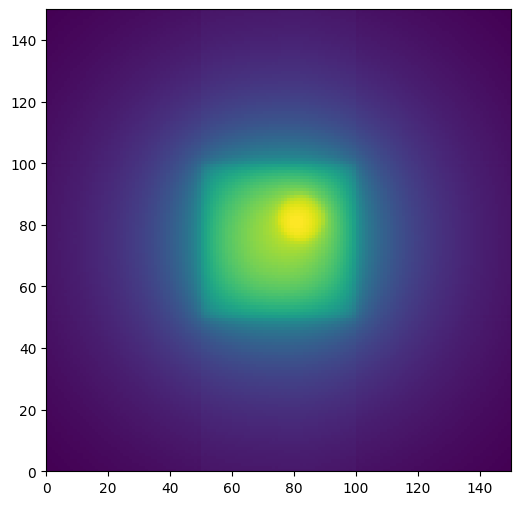

In [9]:
plt.figure(figsize=(6,6))
plt.pcolor(fBP)
plt.show()

### Filtered Backprojection

In [10]:
#TODO lol 

# Using SkImage

In [11]:
from skimage.data import shepp_logan_phantom
from skimage.transform import radon, rescale, iradon

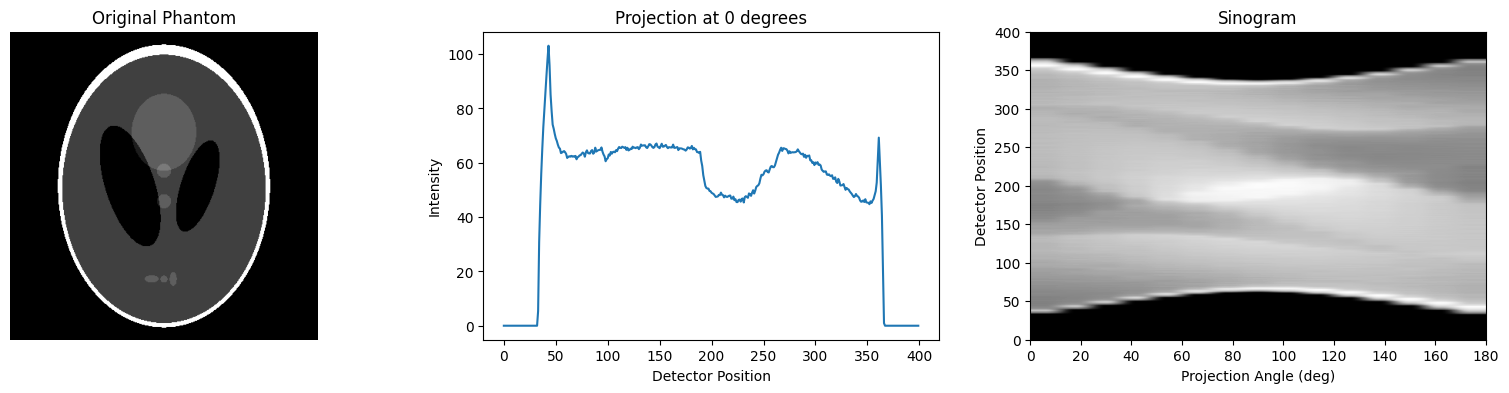

In [12]:
phantom = shepp_logan_phantom()
thetas = np.linspace(-50,50,15)
intensities = radon(phantom, thetas)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))
# ax1 is the original phantom
# ax2 is the a single projection at 0 degrees
# ax3 is the sinogram

ax1.imshow(phantom, cmap=plt.cm.Greys_r)
ax1.set_title("Original Phantom")
ax1.axis('off')

ax2.plot(intensities[:,0])
ax2.set_title("Projection at 0 degrees")
ax2.set_xlabel("Detector Position")
ax2.set_ylabel("Intensity")

ax3.set_title("Sinogram")
ax3.set_xlabel("Projection Angle (deg)")
ax3.set_ylabel("Detector Position")
ax3.imshow(intensities, cmap=plt.cm.Greys_r, extent=(0, 180, 0, intensities.shape[0]), aspect='auto')

plt.show()

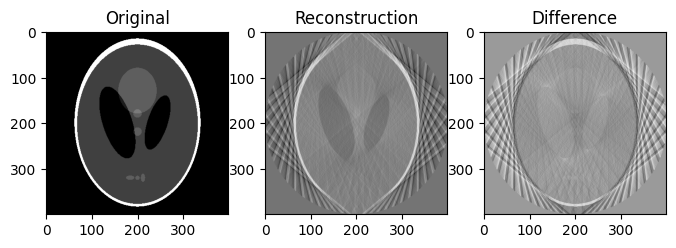

In [13]:
reconstruction_fbp = iradon(intensities, theta=thetas, filter_name='ramp')

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 4.5))
ax1.set_title("Original")
ax1.imshow(phantom, cmap=plt.cm.Greys_r)
ax2.set_title("Reconstruction")
ax2.imshow(reconstruction_fbp, cmap=plt.cm.Greys_r)
ax3.set_title("Difference")
ax3.imshow(phantom - reconstruction_fbp, cmap=plt.cm.Greys_r)
plt.show()
